In [1]:
!pip install tensorflow==2.5.0

In [2]:
#impoting library tensor dataset use to bulild calssify model in pipeline

import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
# we will use tf datastructre which will help us to achive pipeline
# it haave some other function which will help to filter image and other stuff
#tensor also help to convert image into numpy numbes
# it handles dataset  by streaming them from disk using batching

In [11]:
!pip install numpy

In [12]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [13]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [35]:
class_names=dataset.class_names
class_names
n_classes = len(class_names)


In [36]:
len(dataset)

68

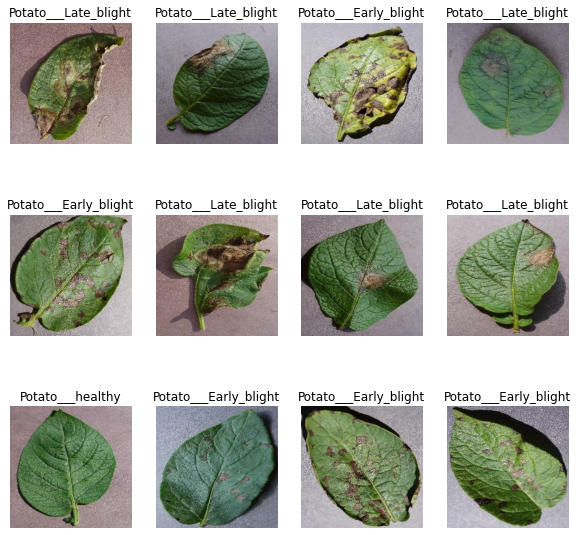

In [37]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        #print(image_batch[0].numpy())

In [38]:
len(dataset)

68

In [39]:
""""train-80%
test-10%
validate-10%"""

'"train-80%\ntest-10%\nvalidate-10%'

In [40]:
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [41]:
train_ds=dataset.take(54)#it is same test train spit
len(train_ds)

54

In [42]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [43]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [44]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [45]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [46]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    test_size=int(test_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    return train_ds,val_ds,test_ds
    

In [47]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [48]:
len(train_ds)

54

In [49]:
len(val_ds)

6

In [50]:
len(test_ds)

8

In [51]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [53]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [54]:
from tensorflow.keras import backend as K
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [55]:

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 126s 2s/step - loss: 0.8850 - accuracy: 0.4907 - val_loss: 0.9573 - val_accuracy: 0.4062
Epoch 2/50
54/54 [==============================] - 96s 2s/step - loss: 0.7084 - accuracy: 0.6632 - val_loss: 0.5777 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 93s 2s/step - loss: 0.5310 - accuracy: 0.7743 - val_loss: 0.4862 - val_accuracy: 0.7500
Epoch 4/50
54/54 [==============================] - 94s 2s/step - loss: 0.3957 - accuracy: 0.8397 - val_loss: 0.2416 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 95s 2s/step - loss: 0.5793 - accuracy: 0.7390 - val_loss: 0.4284 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.4378 - accuracy: 0.8067 - val_loss: 0.4958 - val_accuracy: 0.7865
Epoch 7/50
54/54 [==============================] - 100s 2s/step - loss: 0.3239 - accuracy: 0.8733 - val_loss: 0.4429 - val_accuracy: 0.8281
Epoch 8/50
54/54 [

In [ ]:
score=model.evaluate(test_ds)

In [ ]:
score

In [ ]:
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual Lable:",class_names[labels_batch[0].numpy()])
    batch_prediction=model.predict(images_batch)
    print("Predicted lable",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
import os
model_version = max([int(i) for i in (os.listdir("../saved_models")+[0])]) + 1
model.save(f"../models/{model_version}")

In [ ]:
tf.__version__